Para abrir o notebook no Google Colab, altere o domínio `github.com` para `githubtocolab.com`

<div class="alert alert-block alert-danger">
Para praticar programação, é importante que você erre, leia as mensagens de erro e tente corrigí-los.
    
Dessa forma, no Google Colab, é importante que você DESATIVE OS RECURSOS DE AUTOCOMPLETAR:

- Menu Ferramentas -> Configurações
- Na janela que é aberta:
  - Seção Editor -> Desativar "Mostrar sugestões de preenchimento de código com base no contexto"
  - Seção Assistência de IA -> Desabilitar itens

Na versão em inglês:

- Menu Tools -> Settings
- Na janela que é aberta:
  - Seção Editor -> Desativar "Show context-powered code completions"
  - Seção AI Assistance -> Desabilitar itens
</div>

# PSI5892 - Aula de Exercícios

# Análise de componentes principais (PCA) e análise de discriminantes lineares (LDA)

Neste exercício, você vai trabalhar com uma aplicação de redes neurais para  para a área de saúde. O objetivo é obter um modelo de predição de uma doença cardíaca baseado em dados com características extraídas de exames clínicos laboratoriais.

## Dados disponibilizados

Os dados para treinamento e teste do modelo estão disponíveis no formato CSV, em um arquivo zip disponível [neste link](./data.zip).

Após extrair os arquivos, utiliza a biblioteca Pandas para carregar os `DataFrames` `data_train` e `data_test`, como mostrado a seguir:

``` python
import pandas as pd

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])

data_test = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])
```

Os dados consistem de 800 exemplos de treinamento e 225 para teste, cada um contendo 13 características de entrada, representadas pelas colunas de 0 a 12 e a saída desejada binária, indicando se o paciente é portador ou não da doença, representada pela coluna 13.

O objetivo é treinar uma rede neural com estes dados, avaliar o desempenho e depois comparar com o desempenho obtido usando o PCA para realizar redução de dimensionalidade. Use como referência o exemplo mostrado [neste Jupyter Notebook](./PCA_IRIS.ipynb)

# Exercício 1

Implemente uma rede neural para classificar se o indivíduo é portador ou não da doença cardíaca (coluna 13) usando como entrada os dados dos exames laboratoriais (colunas 1 a 12). Calcule a acurácia obtida nos dados de teste.

## Resolução

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Carregamento dos dados

data_train = pd.read_csv("data_train.csv").drop(columns=["Unnamed: 0"])
data_test = pd.read_csv("data_test.csv").drop(columns=["Unnamed: 0"])

In [3]:
data_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,52.0,1.0,0.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,2.0,3.0,0.0
1,53.0,1.0,0.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0,0.0
2,70.0,1.0,0.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,0.0,3.0,0.0
3,61.0,1.0,0.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,2.0,1.0,3.0,0.0
4,62.0,0.0,0.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,1.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,62.0,1.0,1.0,128.0,208.0,1.0,0.0,140.0,0.0,0.0,2.0,0.0,2.0,1.0
796,41.0,1.0,1.0,135.0,203.0,0.0,1.0,132.0,0.0,0.0,1.0,0.0,1.0,1.0
797,65.0,0.0,0.0,150.0,225.0,0.0,0.0,114.0,0.0,1.0,1.0,3.0,3.0,0.0
798,59.0,1.0,3.0,170.0,288.0,0.0,0.0,159.0,0.0,0.2,1.0,0.0,3.0,0.0


In [4]:
n_total = len(data_train)
n_treino = int(n_total * 0.8) # Divisão 80/20 (treino/validação)

indices_aleatorios = np.random.permutation(n_total)

indices_treino = indices_aleatorios[:n_treino]
indices_val = indices_aleatorios[n_treino:]

# DataFrames de treino e validação
df_treino = data_train.iloc[indices_treino]
df_val = data_train.iloc[indices_val]

print(len(df_treino))
print(len(df_val))

# Dados de treino
x_treino_np = df_treino.iloc[:, :-1].to_numpy()
d_treino_np = df_treino.iloc[:, -1].to_numpy()

# Dados de validação
x_val_np = df_val.iloc[:, :-1].to_numpy()
d_val_np = df_val.iloc[:, -1].to_numpy()

# ============================================================== #
# Normalizar os dados de treino e val

# Calcula a média das características
media_treino = np.mean(x_treino_np, axis=0)

# Calcula o desvio padrao das características
desvio_padrao_treino = np.std(x_treino_np, axis=0, ddof=1)

# Aplica a normalização no conjunto
x_treino_np_norm = (x_treino_np - media_treino) / desvio_padrao_treino
x_val_np_norm = (x_val_np - media_treino) / desvio_padrao_treino

# ============================================================== #
# Converter para tensores PyTorch
x_treino_tensor = torch.tensor(x_treino_np_norm, dtype=torch.float32)
d_treino_tensor = torch.tensor(d_treino_np, dtype=torch.long)

x_val_tensor = torch.tensor(x_val_np_norm, dtype=torch.float32)
d_val_tensor = torch.tensor(d_val_np, dtype=torch.long)

# print(f"x_treino: {x_treino_np.shape}")
# print(f"d_treino: {d_treino_np.shape}")
# print(f"x_val: {x_val_np.shape}")
# print(f"d_val: {d_val_np.shape}")

640
160


In [5]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(13, 8),
        nn.ReLU(),

        nn.Linear(8, 4),
        nn.ReLU(),

        nn.Linear(4, 4),
        nn.ReLU(),

        nn.Linear(4, 2),
    )

    self._init_weights()

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

        # Inicializa os bias com zero
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

  def forward(self, x):
    output = self.model(x)
    return output

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device=device)

# Taxa de aprendizado
eta = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=eta)

Nb = 64 # Tamanho do mini-batch
Ne = 1000 # Número de épocas


In [7]:

train_set = TensorDataset(x_treino_tensor, d_treino_tensor)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=Nb, shuffle=True)

Epoch: 0 | Loss: 1.7540206909179688 | Val. Loss: 1.5266128778457642
Epoch: 1 | Loss: 1.5860364437103271 | Val. Loss: 1.3925654888153076
Epoch: 2 | Loss: 1.5156325101852417 | Val. Loss: 1.2720091342926025
Epoch: 3 | Loss: 1.2544071674346924 | Val. Loss: 1.1686512231826782
Epoch: 4 | Loss: 1.5605430603027344 | Val. Loss: 1.0788377523422241
Epoch: 5 | Loss: 1.1205859184265137 | Val. Loss: 1.002772331237793
Epoch: 6 | Loss: 1.0684101581573486 | Val. Loss: 0.9403995275497437
Epoch: 7 | Loss: 0.8697930574417114 | Val. Loss: 0.8889294862747192
Epoch: 8 | Loss: 1.0309972763061523 | Val. Loss: 0.8491054773330688
Epoch: 9 | Loss: 0.9097887873649597 | Val. Loss: 0.8140474557876587
Epoch: 10 | Loss: 0.7565056681632996 | Val. Loss: 0.783333957195282
Epoch: 11 | Loss: 0.8276523947715759 | Val. Loss: 0.7580941915512085
Epoch: 12 | Loss: 0.671380877494812 | Val. Loss: 0.7377622127532959
Epoch: 13 | Loss: 0.6934356093406677 | Val. Loss: 0.718569815158844
Epoch: 14 | Loss: 0.6616615056991577 | Val. Loss

Text(0, 0.5, 'Loss')

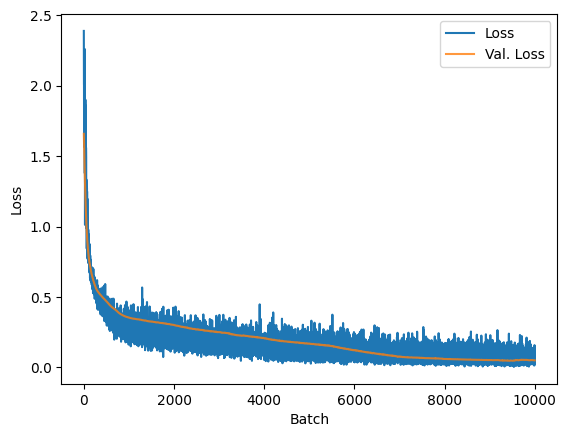

In [8]:
# Treinamento
losses = []
val_losses = []

x_val_tensor = x_val_tensor.to(device=device)
d_val_tensor = d_val_tensor.to(device=device)

for epoch in range(Ne):
  for n, (X, d) in enumerate(train_loader):

    X = X.to(device=device)
    d = d.to(device=device)

    # Treinamento
    model.train()
    model.zero_grad()
    y = model(X)
    loss = loss_function(y, d)
    loss.backward()
    optimizer.step()

    # Validação
    model.eval()

    with torch.no_grad():
      y_val = model(x_val_tensor)
      val_loss = loss_function(y_val, d_val_tensor)

    losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 1 == 0 and n == x_treino_tensor.shape[0]//Nb - 1:
      print(f"Epoch: {epoch} | Loss: {loss} | Val. Loss: {val_loss}")

plt.figure()
plt.plot(losses)
plt.plot(val_losses, alpha=0.8)
plt.legend(["Loss", "Val. Loss"])
plt.xlabel("Batch")
plt.ylabel("Loss")


In [9]:
# Testando o modelo

# Converte os dados de teste em arrays numpy
x_teste_np = data_test.iloc[:, :-1].to_numpy()
d_teste_np = data_test.iloc[:, -1].to_numpy()

# Aplica a normalização no conjunto de teste
x_teste_np_norm = (x_teste_np - media_treino) / desvio_padrao_treino

# Converte os arrays numpy em tensores PyTorch
x_teste_tensor = torch.tensor(x_teste_np_norm, dtype=torch.float32).to(device=device)
d_teste_tensor = torch.tensor(d_teste_np, dtype=torch.long).to(device=device)

# Testa o modelo com os dados de teste
y_teste_tensor = model(x_teste_tensor)
y_teste_np = y_teste_tensor.cpu().detach().numpy()

predicoes = np.argmax(y_teste_np, axis=1)
acuracia = np.mean(predicoes == d_teste_np)

# Taxa de erros

Taxa_de_erro = (1 - acuracia) * 100

print(f"Acurácia: {acuracia*100:.2f}%")
print(f"Taxa de erro: {Taxa_de_erro:.2f}%")

Acurácia: 94.22%
Taxa de erro: 5.78%


In [10]:
data_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,67.0,1.0,0.0,120.0,229.0,0.0,0.0,129.0,1.0,2.6,1.0,2.0,3.0,0.0
1,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
2,63.0,0.0,0.0,124.0,197.0,0.0,1.0,136.0,1.0,0.0,1.0,0.0,2.0,0.0
3,52.0,1.0,0.0,112.0,230.0,0.0,1.0,160.0,0.0,0.0,2.0,1.0,2.0,0.0
4,58.0,0.0,0.0,130.0,197.0,0.0,1.0,131.0,0.0,0.6,1.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,59.0,1.0,1.0,140.0,221.0,0.0,1.0,164.0,1.0,0.0,2.0,0.0,2.0,1.0
221,60.0,1.0,0.0,125.0,258.0,0.0,0.0,141.0,1.0,2.8,1.0,1.0,3.0,0.0
222,47.0,1.0,0.0,110.0,275.0,0.0,0.0,118.0,1.0,1.0,1.0,1.0,2.0,0.0
223,50.0,0.0,0.0,110.0,254.0,0.0,0.0,159.0,0.0,0.0,2.0,0.0,2.0,1.0


# Exercício 2

Aplique o PCA nos dados de entrada e obtenha uma matriz de dados transformados representando os 12 componentes principais. Mostre o valor da porcentagem de variância explicada acumulada à medida que você considera um maior número de componentes principais.

## Resolução

In [11]:
# Vamos aplicar a PCA sobre os dados normalizados

# x_treino_np_norm
# d_treino_np
# x_val_np_norm
# d_val_np

# D: número de características
# N: número de exemplos
# M: número de características no espaço projetado

# P = UX (M X N)
# U = matriz com os autovetores da matriz de covariância dos dados (M X D)
# X = matriz com os dados normalizados (D X N)

X_treino = x_treino_np_norm.T
N_treino = X_treino.shape[1]

# Matriz de covariância dos dados de treino
S_treino = (X_treino @ X_treino.T) / N_treino # (D X D)

autovalores, autovetores = np.linalg.eig(S_treino)

# Ordenar os autovalores em ordem decrescente
indices_ordenados = np.argsort(autovalores)
indices_decrescente = indices_ordenados[::-1]

autovalores = autovalores[indices_decrescente]
autovetores = autovetores[:, indices_decrescente]

# Variância explicada
var_explicada = (autovalores / np.sum(autovalores)) * 100

# Variância acumulada
var_acumulada = np.cumsum(var_explicada)

print(f"{'M':<5} | {'Variância acumulada (%)'}")
print("-" * 30)

for i, variancia in enumerate(var_acumulada):
  M = i + 1
  print(f"{M:<5} | {variancia:.2f}%")


M     | Variância acumulada (%)
------------------------------
1     | 22.11%
2     | 34.00%
3     | 43.55%
4     | 52.42%
5     | 60.26%
6     | 67.69%
7     | 74.29%
8     | 80.06%
9     | 85.54%
10    | 90.26%
11    | 94.04%
12    | 97.32%
13    | 100.00%


In [12]:
# Projetar dados com M = 12 componentes principais

M = 12
U = autovetores[:, :M].T

# Transformação linear P = UX
P_treino = U @ X_treino
print("Matriz dos dados transformados no subespaço de dimensão M=12")
print(P_treino)

Matriz dos dados transformados no subespaço de dimensão M=12
[[ 2.60376974  0.31853518  3.81315614 ... -0.19022757 -0.77921265
  -2.29611227]
 [-0.74405806  0.08056353  2.21133775 ...  0.15490221  0.23595092
   0.19570328]
 [-0.79261968  1.32999366  0.97762609 ... -0.81254837 -0.55148643
   0.06866296]
 ...
 [-0.94073426  1.02264157  0.12845426 ...  1.09006002 -1.14752368
   0.92916888]
 [ 0.59545994 -1.66002031  0.5358125  ...  0.72415479 -0.18040992
  -0.46054079]
 [-0.44770539 -0.16597185  0.85797342 ... -0.45465562  0.76734171
  -0.49617354]]


# Exercício 3

Implemente uma segunda rede neural para fazer a classificação usando o número de componentes principais necessário para incluir 90% da variância explicada. Calcule a acurácia obtida nos dados de teste.

## Resolução

Como vimos na tabela do exercício 2, o número mínimo de componentes principais necessário para incluir 90% da variância explicada é M=10.

In [13]:
M = 10
U = autovetores[:, :M].T

# Transformação linear P = UX
P_treino = U @ X_treino

# Projetando também nos dados de validação
X_val = x_val_np_norm.T
P_val = U @ X_val

# Convertendo em tensores Pytorch
x_treino_pca = torch.tensor(P_treino.T, dtype=torch.float32)
x_val_pca = torch.tensor(P_val.T, dtype=torch.float32)

# Vou definir d_treino_tensor e d_val_tensor de novo mas é o mesmo
d_treino_tensor = torch.tensor(d_treino_np, dtype=torch.long)
d_val_tensor = torch.tensor(d_val_np, dtype=torch.long)

In [14]:
class ModelPCA(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(10, 8),
        nn.ReLU(),

        nn.Linear(8, 4),
        nn.ReLU(),

        nn.Linear(4, 4),
        nn.ReLU(),

        nn.Linear(4, 2),
    )

    self._init_weights()

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

        # Inicializa os bias com zero
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

  def forward(self, x):
    output = self.model(x)
    return output

In [15]:

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Aqui muda
model_pca = ModelPCA().to(device=device)

# Taxa de aprendizado
eta = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pca.parameters(), lr=eta)

Nb = 64 # Tamanho do mini-batch
Ne = 1000 # Número de épocas


In [16]:

train_set_pca = TensorDataset(x_treino_pca, d_treino_tensor)
train_loader_pca = torch.utils.data.DataLoader(train_set_pca, batch_size=Nb, shuffle=True)

Epoch: 0 | Loss: 1.8583680391311646 | Val. Loss: 1.6212027072906494
Epoch: 1 | Loss: 1.2970407009124756 | Val. Loss: 1.449122667312622
Epoch: 2 | Loss: 1.301961898803711 | Val. Loss: 1.300028681755066
Epoch: 3 | Loss: 1.4774218797683716 | Val. Loss: 1.1757051944732666
Epoch: 4 | Loss: 1.1729419231414795 | Val. Loss: 1.0705630779266357
Epoch: 5 | Loss: 1.2837003469467163 | Val. Loss: 0.9826695322990417
Epoch: 6 | Loss: 1.0554507970809937 | Val. Loss: 0.9121969938278198
Epoch: 7 | Loss: 0.9681206941604614 | Val. Loss: 0.8536349534988403
Epoch: 8 | Loss: 0.9146990776062012 | Val. Loss: 0.8064015507698059
Epoch: 9 | Loss: 0.7406601309776306 | Val. Loss: 0.7673071622848511
Epoch: 10 | Loss: 0.6684960126876831 | Val. Loss: 0.7360856533050537
Epoch: 11 | Loss: 0.7201763987541199 | Val. Loss: 0.7101364731788635
Epoch: 12 | Loss: 0.7385163307189941 | Val. Loss: 0.687412679195404
Epoch: 13 | Loss: 0.6577675342559814 | Val. Loss: 0.6675390005111694
Epoch: 14 | Loss: 0.6953451633453369 | Val. Loss

Text(0, 0.5, 'Loss')

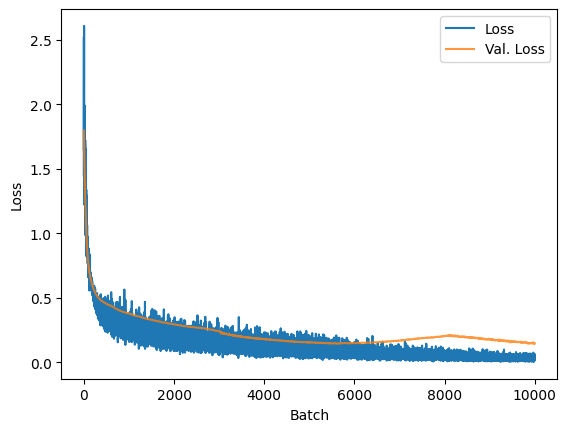

In [17]:
# Treinamento
losses = []
val_losses = []

x_val_pca = x_val_pca.to(device=device)
d_val_tensor = d_val_tensor.to(device=device)

for epoch in range(Ne):
  for n, (X, d) in enumerate(train_loader_pca):

    X = X.to(device=device)
    d = d.to(device=device)

    # Treinamento
    model_pca.train()
    model_pca.zero_grad()
    y = model_pca(X)
    loss = loss_function(y, d)
    loss.backward()
    optimizer.step()

    # Validação
    model_pca.eval()

    with torch.no_grad():
      y_val = model_pca(x_val_pca)
      val_loss = loss_function(y_val, d_val_tensor)

    losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 1 == 0 and n == x_treino_pca.shape[0]//Nb - 1:
      print(f"Epoch: {epoch} | Loss: {loss} | Val. Loss: {val_loss}")

plt.figure()
plt.plot(losses)
plt.plot(val_losses, alpha=0.8)
plt.legend(["Loss", "Val. Loss"])
plt.xlabel("Batch")
plt.ylabel("Loss")


In [18]:
# Testando o modelo

# Converte os dados de teste em arrays numpy
# x_teste_np = data_test.iloc[:, :-1].to_numpy()
# d_teste_np = data_test.iloc[:, -1].to_numpy()

# Aplica a normalização no conjunto de teste
# x_teste_np_norm = (x_teste_np - media_treino) / desvio_padrao_treino

# Projeta o teste
x_teste_pca = (U @ x_teste_np_norm.T)
x_teste_pca = x_teste_pca.T

# Converte os arrays numpy em tensores PyTorch
x_teste_pca = torch.tensor(x_teste_pca, dtype=torch.float32).to(device=device)
d_teste_tensor = torch.tensor(d_teste_np, dtype=torch.long).to(device=device)

# Testa o modelo com os dados de teste
y_teste_tensor_pca = model_pca(x_teste_pca)
y_teste_np = y_teste_tensor_pca.cpu().detach().numpy()

predicoes_pca = np.argmax(y_teste_np, axis=1)
acuracia_pca = np.mean(predicoes_pca == d_teste_np)

# Taxa de erros

Taxa_de_erro_pca = (1 - acuracia_pca) * 100

print(f"Acurácia: {acuracia_pca*100:.2f}%")
print(f"Taxa de erro: {Taxa_de_erro_pca:.2f}%")

Acurácia: 96.89%
Taxa de erro: 3.11%


# Exercício 4

Repita os exercícios 1, 2 e 3, considerando a transformação dos dados usando o LDA no lugar do PCA. Use como referência o exemplo mostrado [neste Jupyter Notebook](./LDA_IRIS.ipynb)

## Resolução

In [19]:
# yn = W.T @ X

X_raw = x_treino_np
d_raw = d_treino_np
N, D = X_raw.shape

# Média global
# m = (1/N) * sum(x_n)
m_global = np.mean(X_raw, axis=0).reshape(-1, 1)


# Matrizes de dispersão
Sw = np.zeros((D, D)) # Dentro das classes
Sb = np.zeros((D, D)) # Entre classes

classes = np.unique(d_raw);

for k in classes:
  X_k = X_raw[d_raw == k]
  N_k = X_k.shape[0]

  # Média da classe k
  m_k = np.mean(X_k, axis=0).reshape(-1, 1)

  # Sw = (X_k - m_k) @ (X_k - m_k).T
  S_k = (X_k - m_k.T).T @ (X_k - m_k.T) # Somatório interno (em D)
  Sw += S_k # Somatório externo (k=1 até K)

  # Sb
  Sb_k = N_k * ((m_k - m_global) @ (m_k - m_global).T)
  Sb += Sb_k

# Sw^-1 * Sb * W = lambda * w
# Av = lambda * v (forma de autovalor-autovetor)
# Vemos que W é o autovetor associado ao autovalor não nulo lambda
Sw_inversa = np.linalg.inv(Sw)
A = Sw_inversa @ Sb

autovalores, autovetores = np.linalg.eig(A)

autovalores = autovalores.real
autovetores = autovetores.real

indices_ordenados = np.argsort(autovalores)[::-1]
autovalores = autovalores[indices_ordenados]
autovetores = autovetores[:, indices_ordenados]

# Somente um autovalor é não-nulo
print(autovalores)

[ 1.23286021e+00  5.77883828e-17  2.19177081e-17  9.13183191e-18
  9.13183191e-18  5.36556955e-19  5.36556955e-19  0.00000000e+00
 -8.74836566e-18 -8.74836566e-18 -3.34834632e-17 -8.13863938e-17
 -2.13458097e-16]


In [20]:
W = autovetores[:, :1]

# Agora que temos o vetor W, vamos aplicar a transformação
# yn = W.T @ Xn

y_treino = X_raw @ W
y_val = x_val_np @ W
y_teste = x_teste_np @ W

x_treino_lda = torch.tensor(y_treino, dtype=torch.float32)
d_treino_tensor = torch.tensor(d_treino_np, dtype=torch.long)

x_val_lda = torch.tensor(y_val, dtype=torch.float32)
d_val_tensor = torch.tensor(d_val_np, dtype=torch.long)

x_teste_lda = torch.tensor(y_teste, dtype=torch.float32)
d_teste_tensor = torch.tensor(d_teste_np, dtype=torch.long)


In [21]:
class ModelLDA(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(1, 8),
        nn.ReLU(),

        nn.Linear(8, 4),
        nn.ReLU(),

        nn.Linear(4, 4),
        nn.ReLU(),

        nn.Linear(4, 2),
    )

    self._init_weights()

  def _init_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

        # Inicializa os bias com zero
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)

  def forward(self, x):
    output = self.model(x)
    return output

In [22]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Aqui muda
model_lda = ModelLDA().to(device=device)

# Taxa de aprendizado
eta = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lda.parameters(), lr=eta)

Nb = 64 # Tamanho do mini-batch
Ne = 1000 # Número de épocas


In [23]:

train_set_lda = TensorDataset(x_treino_lda, d_treino_tensor)
train_loader_lda = torch.utils.data.DataLoader(train_set_lda, batch_size=Nb, shuffle=True)

Epoch: 0 | Loss: 0.7888780236244202 | Val. Loss: 0.9000808000564575
Epoch: 1 | Loss: 0.7823255658149719 | Val. Loss: 0.8310191035270691
Epoch: 2 | Loss: 0.7842394113540649 | Val. Loss: 0.7755982875823975
Epoch: 3 | Loss: 0.7573270797729492 | Val. Loss: 0.731992244720459
Epoch: 4 | Loss: 0.7155287861824036 | Val. Loss: 0.6985521912574768
Epoch: 5 | Loss: 0.6654696464538574 | Val. Loss: 0.6719021201133728
Epoch: 6 | Loss: 0.6633478403091431 | Val. Loss: 0.6499989628791809
Epoch: 7 | Loss: 0.6159043908119202 | Val. Loss: 0.633156955242157
Epoch: 8 | Loss: 0.6263265609741211 | Val. Loss: 0.6211758852005005
Epoch: 9 | Loss: 0.5996385216712952 | Val. Loss: 0.6101387739181519
Epoch: 10 | Loss: 0.5482754111289978 | Val. Loss: 0.5993477702140808
Epoch: 11 | Loss: 0.582712709903717 | Val. Loss: 0.589074969291687
Epoch: 12 | Loss: 0.5098328590393066 | Val. Loss: 0.5793178081512451
Epoch: 13 | Loss: 0.5244101285934448 | Val. Loss: 0.5699729919433594
Epoch: 14 | Loss: 0.5759801864624023 | Val. Loss

Text(0, 0.5, 'Loss')

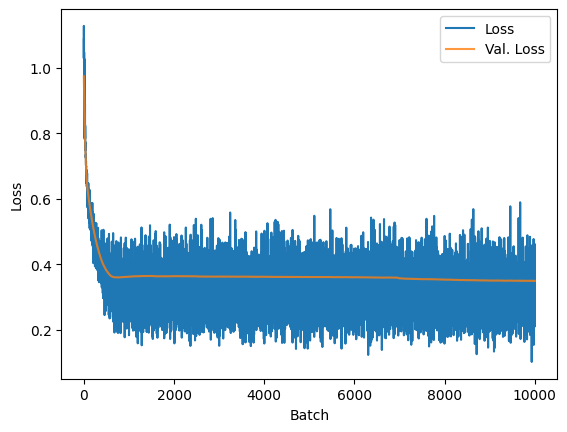

In [24]:
# Treinamento
losses = []
val_losses = []

x_val_lda = x_val_lda.to(device=device)
d_val_tensor = d_val_tensor.to(device=device)

for epoch in range(Ne):
  for n, (X, d) in enumerate(train_loader_lda):

    X = X.to(device=device)
    d = d.to(device=device)

    # Treinamento
    model_lda.train()
    model_lda.zero_grad()
    y = model_lda(X)
    loss = loss_function(y, d)
    loss.backward()
    optimizer.step()

    # Validação
    model_lda.eval()

    with torch.no_grad():
      y_val = model_lda(x_val_lda)
      val_loss = loss_function(y_val, d_val_tensor)

    losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 1 == 0 and n == x_treino_lda.shape[0]//Nb - 1:
      print(f"Epoch: {epoch} | Loss: {loss} | Val. Loss: {val_loss}")

plt.figure()
plt.plot(losses)
plt.plot(val_losses, alpha=0.8)
plt.legend(["Loss", "Val. Loss"])
plt.xlabel("Batch")
plt.ylabel("Loss")


In [25]:
# Testando o modelo

# Converte os dados de teste em arrays numpy
x_teste_np = data_test.iloc[:, :-1].to_numpy()
d_teste_np = data_test.iloc[:, -1].to_numpy()

# Aplica a normalização no conjunto de teste
# x_teste_np_norm = (x_teste_np - media_treino) / desvio_padrao_treino

# Testa o modelo com os dados de teste
y_teste_tensor_lda = model_lda(x_teste_lda)
y_teste_np = y_teste_tensor_lda.cpu().detach().numpy()

predicoes_lda = np.argmax(y_teste_np, axis=1)
acuracia_lda = np.mean(predicoes_lda == d_teste_np)

# Taxa de erros

Taxa_de_erro_lda = (1 - acuracia_lda) * 100

print(f"Acurácia: {acuracia_lda*100:.2f}%")
print(f"Taxa de erro: {Taxa_de_erro_lda:.2f}%")

Acurácia: 80.00%
Taxa de erro: 20.00%
